# **Mapping Fields from 1D Channel Flow Simulation**

In [1]:
from itertools import cycle
from glob import glob
from typing import List, Tuple
from os.path import isdir
import numpy as np
import torch as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Make results reproducible
pt.manual_seed(0)
# Increase plot resolution
plt.rcParams["figure.dpi"] = 160
# Set paths and create output directory
run = "../run/"
output = "output"
!mkdir -p $output

## 1. Data loading

In [2]:
field1d_path = run + 'channelFlow1D_Re10Mil_time0.05/extractData.csv'
field1d_data = pd.read_csv(field1d_path, delim_whitespace=False)

# To transform y-coordinates (y_face) to elements of the csv file
field1d_data = field1d_data.set_index('y_face').T.rename_axis('y_face').rename_axis(None, axis=1).reset_index()
field1d_data.head()

,y_face,0.001sec_avgU,0.001sec_dUdy_wall,0.001sec_dUdy_face,0.001sec_Ux_face,0.002sec_avgU,0.002sec_dUdy_wall,0.002sec_dUdy_face,0.002sec_Ux_face,0.003sec_avgU,...,0.048sec_dUdy_face,0.048sec_Ux_face,0.049sec_avgU,0.049sec_dUdy_wall,0.049sec_dUdy_face,0.049sec_Ux_face,0.05sec_avgU,0.05sec_dUdy_wall,0.05sec_dUdy_face,0.05sec_Ux_face
0,3.735204068e-05,16.513300,884198.008964,425472.839106,24.459439,14.370200,769446.581145,409559.291357,22.019138,13.244700,...,334313.904942,14.529483,8.264700,442530.038495,333839.075925,14.499485,8.243980,441420.594426,333371.952583,14.470041
1,7.526919948e-05,24.579661,884198.008964,172249.011356,35.791397,22.134862,769446.581145,158014.897085,32.779538,20.875011,...,143278.217543,23.583951,14.593815,442530.038495,143246.807213,23.544356,14.564239,441420.594426,143215.396884,23.505460
2,0.0001137600264,29.494798,884198.008964,96952.192792,40.972285,26.765446,769446.581145,84240.110067,37.441836,25.400656,...,69612.190128,27.681115,18.555021,442530.038495,69583.826454,27.640370,18.522087,441420.594426,69558.041297,27.600373
3,0.0001528332007,32.913368,884198.008964,69763.448669,44.229340,29.915715,769446.581145,58795.359415,40.236261,28.453900,...,44194.947875,29.904518,21.225322,442530.038495,44161.926763,29.862573,21.190454,441420.594426,44126.365566,29.821379
4,0.000192497533,35.530121,884198.008964,55992.356574,46.723350,32.282539,769446.581145,46208.644986,42.318718,30.729693,...,32614.040112,31.427807,23.185503,442530.038495,32581.511148,31.384562,23.149185,441420.594426,32548.982183,31.342017


In [3]:
# End time of OpenFOAM simulation
end_time = 0.05

# Number of divided time steps, not the actual time
num_step = int((len(field1d_data.columns) - 1)/4.0)

# Number of divided y-coordinates
num_yface = len(field1d_data)

# Change from string to numeric values
field1d_data['y_face'] = pd.to_numeric(field1d_data['y_face'], errors='coerce')
for i in range(num_step):    
    field1d_data.iloc[:, 4*i + 1] = pd.to_numeric(field1d_data.iloc[:, 4*i + 1], errors='coerce')
    field1d_data.iloc[:, 4*i + 2] = pd.to_numeric(field1d_data.iloc[:, 4*i + 2], errors='coerce')
    field1d_data.iloc[:, 4*i + 3] = pd.to_numeric(field1d_data.iloc[:, 4*i + 3], errors='coerce')
    field1d_data.iloc[:, 4*i + 4] = pd.to_numeric(field1d_data.iloc[:, 4*i + 4], errors='coerce')

# Save the related data to pytorch tensors
y_face = pt.tensor(field1d_data['y_face'])
avgU = pt.tensor([field1d_data.iloc[:, 4*i + 1] for i in range(num_step)]).T
dUdy_wall = pt.tensor([field1d_data.iloc[:, 4*i + 2] for i in range(num_step)]).T
dUdy_face = pt.tensor([field1d_data.iloc[:, 4*i + 3] for i in range(num_step)]).T
Ux_face = pt.tensor([field1d_data.iloc[:, 4*i + 4] for i in range(num_step)]).T

# Number of features
num_feature = 2

## 2. Verification of velocity fields

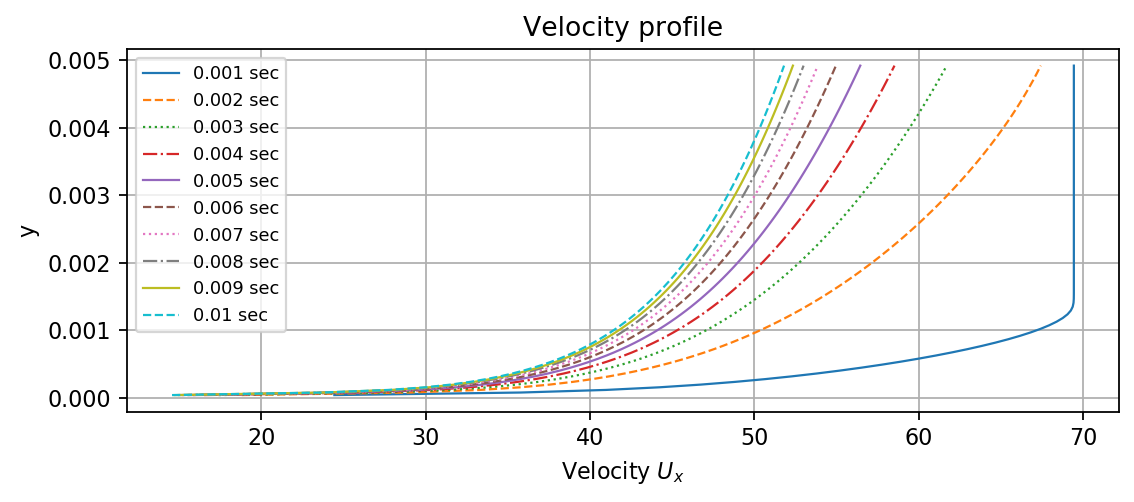

In [4]:
# Plot velocity profiles of 10 time steps
style = ["-", "--", ":", "-."]
lw = 1.0
stylecycler = cycle(style)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))    
plt.grid()
ax.set_xlabel(r"Velocity $U_x$")
ax.set_ylabel(r"y")
plt.title(r"Velocity profile")
for i in range(int(num_step/5)):
    ax.plot(np.array(Ux_face)[:, i*5], np.array(y_face)[:], label = "{} sec".format(round(end_time/num_step*(i+1), int(np.log10(num_step/end_time)))), ls = next(stylecycler), c = "C{:d}".format(i), lw = lw)
    ax.legend(fontsize = 8)

In [5]:
# Constants
KAPPA = 0.41
E = 9.8
nu = 1.388e-5

# Function of Spalding's law for plotting
def spaldings_law(u_plus, E=E, kappa=KAPPA):
    """Evaluate Spalding's law of the wall.
    
    Parameters
    ----------
    u_plus - float: velocity along surface at distance y_plus in wall units
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    
    Returns
    -------
    y_plus - float: distance normal to wall in wall units
    
    """
    return u_plus + 1.0/E * (
        np.exp(kappa*u_plus) - 1.0 - kappa*u_plus - (kappa*u_plus)**2/2.0 - (kappa*u_plus)**3/6.0
    )

u_plus = np.linspace(0, 25, 100)
y_plus = np.array([spaldings_law(up) for up in u_plus])

In [6]:
# Variables for wall units
u_tau = [np.sqrt(nu*0.5*(dUdy_wall[0, i] + dUdy_face[0, i])) for i in range(num_step)]
yp = [y_face*u_tau[i]/nu for i in range(num_step)]
up = [Ux_face[:, i]/u_tau[i] for i in range(num_step)]

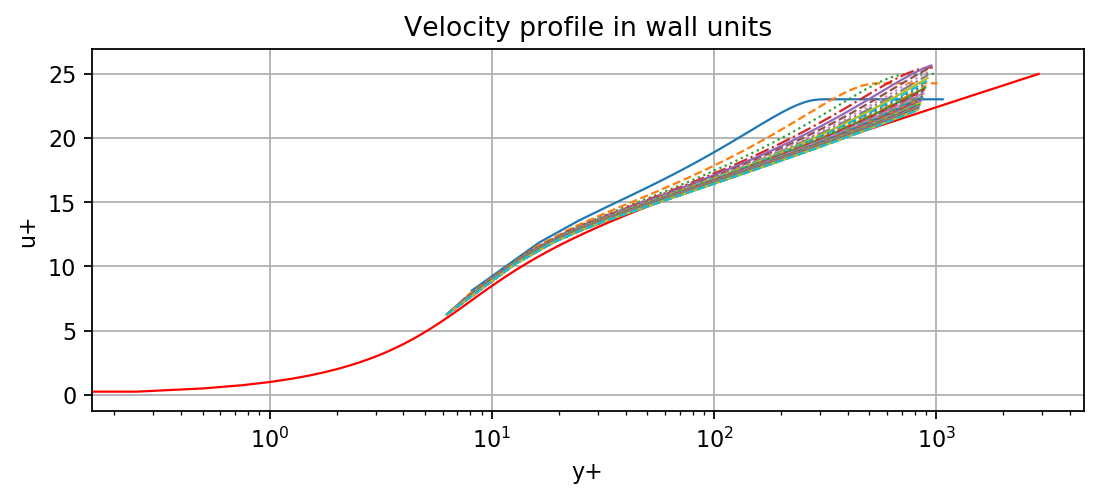

In [7]:
# Comparison of the velocity profiles of 50 time steps (from 0.001 sec to 0.05 sec) and Spalding's law in wall units
style2 = ["-", "--", ":", "-."]
lw2 = 1.0
stylecycler2 = cycle(style2)

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))    
plt.grid()
ax2.set_xscale("log")
ax2.set_xlabel(r"y+")
ax2.set_ylabel(r"u+")
plt.title(r"Velocity profile in wall units")
ax2.plot(y_plus, u_plus, label = "Spalding", ls = style2[0], c = 'r', lw = lw2)
for i in range(num_step):
    ax2.plot(np.array(yp[:][i]), np.array(up[:][i]), label = "{} sec".format(round(end_time/num_step*(i+1), int(np.log10(num_step/end_time)))), ls = next(stylecycler2), c = "C{:d}".format(i), lw = lw2)

## 3. Machine learning

In [8]:
# Create a neural network
class MappingNN(pt.nn.Module):
    """Simple fully-connected neural network.
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.n_inputs = kwargs.get("n_inputs", 1)
        self.n_outputs = kwargs.get("n_outputs", 1)
        self.n_layers = kwargs.get("n_layers", 1)
        self.n_neurons = kwargs.get("n_neurons", 10)
        self.activation = kwargs.get("activation", pt.sigmoid)
        self.layers = pt.nn.ModuleList()
        # Input layer to first hidden layer
        self.layers.append(pt.nn.Linear(self.n_inputs, self.n_neurons))
        # Add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(pt.nn.Linear(
                    self.n_neurons, self.n_neurons))
        # Last hidden layer to output layer
        self.layers.append(pt.nn.Linear(self.n_neurons, self.n_outputs))

    def forward(self, x):
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

    @property
    def model_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [9]:
# Divide the data into 3 parts by using a multinomial method
probs = pt.ones(dUdy_wall.shape[-1])
test_idx = pt.multinomial(probs, 10)
probs[test_idx] = 0.0
val_idx = pt.multinomial(probs, 10)
probs[val_idx] = 0.0
train_idx = pt.multinomial(probs, probs.shape[0]-20)
print("Testing snapshots: ", test_idx)
print("Validation snapshots: ", val_idx)
print("Training snapshots: ", train_idx)

Testing snapshots:  tensor([47, 41, 22, 33, 11,  6, 32, 17, 20, 24])
Validation snapshots:  tensor([ 8, 43, 18, 15, 29, 27, 12, 45, 46, 26])
Training snapshots:  tensor([28, 44, 35, 31, 40, 13,  0, 36,  9, 34, 19,  4, 16, 38, 39,  3, 49, 42,
        14,  2, 30, 21, 10, 37, 48, 23, 25,  5,  7,  1])


In [10]:
# Reshape and normalization of data
def reshape_data(dUdy_wall: pt.Tensor, dUdy_face: pt.Tensor, Ux_face: pt.Tensor, 
                 y_face: pt.Tensor, avgU: pt.Tensor) -> pt.Tensor:
    """Create feature and label vectors.

    Outputs
    -------
    :param dUdy_wall: velocity gradient at wall
    :type dUdy_wall: pt.Tensor
    :param dUdy_face: velocity gradient at cell faces
    :type dUdy_face: pt.Tensor
    :param Ux_face: velocity for x-direction at faces
    :type Ux_face: pt.Tensor
    
    Inputs
    ------
    :param y_face: distance from the wall at the face
    :type y: pt.Tensor
    :param avgU: average velocity profiles by integral fitting method
    :type avgU: pt.Tensor
    
    Return
    ------
    :return: data suitable for training; if there are Ny points normal to
        the wall and Nu different average velocities, the resulting tensor
        has the shape (Ny*Nu, 5)
    :rtype: pt.Tensor
    """
    assert y_face.shape[0] == avgU.shape[0]
    assert dUdy_wall.shape[1] == avgU.shape[1]
    assert dUdy_wall.shape[0] == avgU.shape[0]
    assert dUdy_face.shape[1] == avgU.shape[1]
    assert dUdy_face.shape[0] == avgU.shape[0]
    assert Ux_face.shape[1] == avgU.shape[1]
    assert Ux_face.shape[0] == avgU.shape[0]
    data = pt.zeros((avgU.shape[0]*avgU.shape[1], 5))
    for i in range(avgU.shape[1]):
        start, end = i*avgU.shape[0], (i+1)*avgU.shape[0]
        data[start:end, 0] = dUdy_wall[:, i]
        data[start:end, 1] = dUdy_face[:, i]
        data[start:end, 2] = Ux_face[:, i]
        data[start:end, 3] = y_face
        data[start:end, 4] = avgU[:, i]
    return data


class MinMaxScaler(object):
    """Class to scale/re-scale data to the range [-1, 1] and back.
    """
    def __init__(self):
        self.min = None
        self.max = None
        self.trained = False

    def fit(self, data):
        self.min = data.min(dim=0).values
        self.max = data.max(dim=0).values
        self.trained = True

    def scale(self, data):
        assert self.trained
        assert len(data.shape) == 2
        data_norm = (data - self.min) / (self.max - self.min)
        return 2.0*data_norm - 1.0

    def rescale(self, data_norm):
        assert self.trained
        assert len(data_norm.shape) == 2
        data = (data_norm + 1.0) * 0.5
        return data * (self.max - self.min) + self.min
    
class LogScaler(object):
    """Class to scale/re-scale data to the log scale and back.
    """
    def __init__(self):
        self.min = None
        self.max = None
        self.trained = False

    def fit(self, data):
        self.min = data.min(dim=0).values
        self.max = data.max(dim=0).values
        self.trained = True

    def scale(self, data):
        assert self.trained
        assert len(data.shape) == 2
        data_log = pt.log1p(data)
        return data_log

    def rescale(self, data_norm):
        assert self.trained
        assert len(data_norm.shape) == 2
        data = pt.expm1(data_norm)
        return data

In [11]:
test_data = reshape_data(dUdy_wall[:, test_idx], dUdy_face[:, test_idx], Ux_face[:, test_idx], y_face, avgU[:, test_idx])
val_data = reshape_data(dUdy_wall[:, val_idx], dUdy_face[:, val_idx], Ux_face[:, val_idx], y_face, avgU[:, val_idx])
train_data = reshape_data(dUdy_wall[:, train_idx], dUdy_face[:, train_idx], Ux_face[:, train_idx], y_face, avgU[:, train_idx])

In [12]:
# dUdy values should be rescaled to log scale first
log_scaler = LogScaler()
log_scaler.fit(train_data[:, 0:2])
train_data[:, 0:2] = log_scaler.scale(train_data[:, 0:2])
val_data[:, 0:2] = log_scaler.scale(val_data[:, 0:2])
test_data[:, 0:2] = log_scaler.scale(test_data[:, 0:2])

# Check if the normalization works
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_norm = scaler.scale(train_data)
val_data_norm = scaler.scale(val_data)
test_data_norm = scaler.scale(test_data)
assert pt.isclose(train_data_norm.min(), pt.tensor(-1.0))
assert pt.isclose(train_data_norm.max(), pt.tensor(1.0))
assert pt.allclose(train_data, scaler.rescale(train_data_norm), 1e-4)

# Check for log scale
log_scaler.fit(train_data)
train_data_log = log_scaler.scale(train_data)
assert pt.allclose(train_data, log_scaler.rescale(train_data_log))

print(train_data_norm)
print(val_data_norm)

tensor([[-0.7952,  0.9683, -0.9690, -1.0000, -0.9791],
        [-0.7952,  0.8330, -0.6306, -0.9845, -0.7531],
        [-0.7952,  0.7224, -0.4804, -0.9687, -0.6137],
        ...,
        [ 0.5998, -1.0000,  0.9995,  0.9105,  0.9134],
        [ 0.5998, -1.0000,  0.9995,  0.9549,  0.9177],
        [ 0.5998, -1.0000,  0.9995,  1.0000,  0.9219]])
tensor([[-0.2283,  0.9819, -0.8772, -1.0000, -0.9128],
        [-0.2283,  0.8362, -0.5147, -0.9845, -0.6660],
        [-0.2283,  0.7290, -0.3602, -0.9687, -0.5183],
        ...,
        [-0.7646,  0.1570,  0.4498,  0.9105,  0.3332],
        [-0.7646,  0.1545,  0.4569,  0.9549,  0.3390],
        [-0.7646,  0.1519,  0.4639,  1.0000,  0.3447]])


In [13]:
# Model optimization function
def optimize_model(model: pt.nn.Module, x_train: pt.Tensor, y_train: pt.Tensor,
                   x_val: pt.Tensor, y_val: pt.Tensor, epochs: int=1000,
                   lr: float=0.001, save_best: str="") ->Tuple[List[float], List[float]]:
    """Optimize network weights based on training and validation data.

    Parameters
    ----------
    :param model: neural network model
    :type model: pt.nn.Module
    :param x_train: features for training
    :type x_train: pt.Tensor
    :param y_train: labels for training
    :type y_train: pt.Tensor
    :param x_val: features for validation
    :type x_val: pt.Tensor
    :param y_val: labels for validation
    :type y_val: pt.Tensor
    :param epochs: number of optimization loops, defaults to 1000
    :type epochs: int, optional
    :param lr: learning rate, defaults to 0.001
    :type lr: float, optional
    :param save_best: path where to save best model; no snapshots are saved
        if empty string; defaults to ""
    :type save_best: str, optional
    
    Return
    ------
    :return: lists with training and validation losses for all epochs
    :rtype: Tuple[List[float], List[float]]
    """
    criterion = pt.nn.MSELoss()
    optimizer = pt.optim.Adam(params=model.parameters(), lr=lr)
    best_val_loss, best_train_loss = 1.0e5, 1.0e5
    train_loss, val_loss = [], []
    for e in range(1, epochs+1):
        optimizer.zero_grad()
        prediction = model(x_train).squeeze()
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        with pt.no_grad():
            prediction = model(x_val).squeeze()
            loss = criterion(prediction, y_val)
            val_loss.append(loss.item())
        print("\r", "Training/validation loss epoch {:5d}: {:10.5e}, {:10.5e}".format(
            e, train_loss[-1], val_loss[-1]), end="")
        if isdir(save_best):
            if train_loss[-1] < best_train_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_train.pt")
                best_train_loss = train_loss[-1]
            if val_loss[-1] < best_val_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_val.pt")
                best_val_loss = val_loss[-1]
    return train_loss, val_loss

In [14]:
# First model training with normalized data
save_model_in = f"{output}/first_training_1D/"
!mkdir -p $save_model_in
model_params = {
    "n_inputs": 2,
    "n_outputs": 3,
    "n_layers": 2,
    "n_neurons": 40,
    "activation": pt.nn.ReLU()
}
model = MappingNN(**model_params)
train_loss, val_loss = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3],
                                      val_data_norm[:, 3:], val_data_norm[:, 0:3], 10000, save_best=save_model_in)

 Training/validation loss epoch 10000: 5.31037e-05, 2.98793e-05Training/validation loss epoch   833: 4.71013e-03, 1.29835e-03Training/validation loss epoch  1769: 2.23536e-03, 5.10441e-04Training/validation loss epoch  3211: 6.87442e-04, 2.48729e-04Training/validation loss epoch  6802: 7.10949e-05, 3.86752e-05Training/validation loss epoch  9036: 5.36205e-05, 2.86448e-05Training/validation loss epoch  9084: 5.25289e-05, 2.70980e-05Training/validation loss epoch  9540: 5.10839e-05, 2.64255e-05Training/validation loss epoch  9887: 5.79692e-05, 3.43073e-05

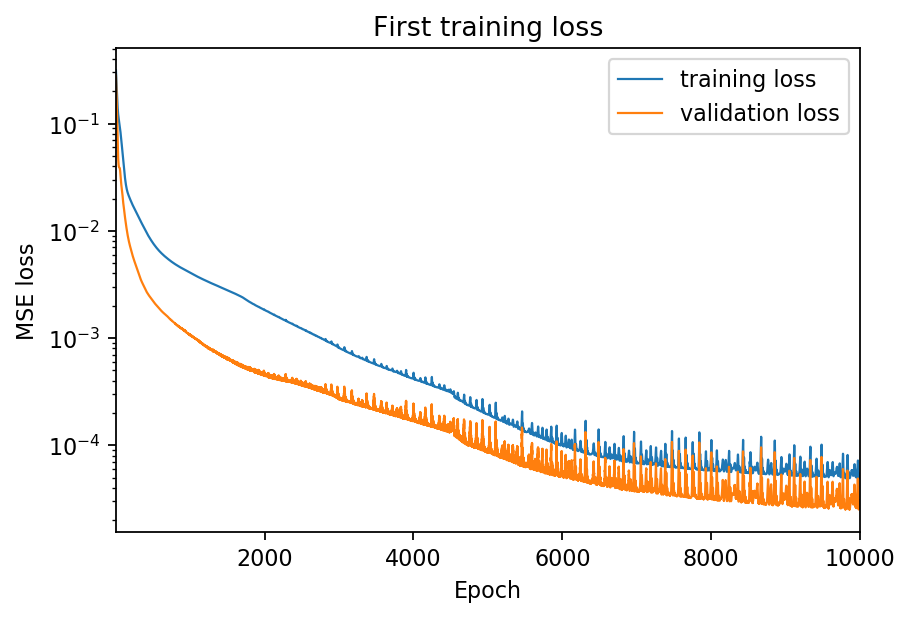

In [15]:
epochs = len(train_loss)
plt.title("First training loss")
plt.plot(range(1, epochs+1), train_loss, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss, lw=1.0, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss.svg", bbox_inches="tight")

In [16]:
# Calculate L_inf
best_model = MappingNN(**model_params)
best_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
prediction = best_model(test_data_norm[:, 3:]).squeeze()
l2 = (prediction - test_data_norm[:, 0:3]).square().mean()
# We normalize the maximum error with the range of the scaled dUdy and Ux_face,
# which is 1-(-1)=2
lmax = (prediction - test_data_norm[:, 0:3]).absolute().max() / 2
print("MSE test loss: {:1.4e}".format(l2))
print("Lmax test loss: {:1.4e}".format(lmax))

MSE test loss: 2.6429e-05
Lmax test loss: 2.2835e-02


In [17]:
# Comparison between the original and trained data
full_data = reshape_data(dUdy_wall, dUdy_face, Ux_face, y_face, avgU)
full_data_norm = scaler.scale(full_data)
full_pred = best_model(full_data_norm[:, 3:]).squeeze()
# Re-use full dataset for rescaling; it would be better to have separate scalers for features and labels
full_data_norm[:, 0:3] = full_pred
prediction = scaler.rescale(full_data_norm).detach()

In [18]:
'''
# Plot true label and trained model
fig_map = plt.figure()
ax_map = Axes3D(fig_map)

ax_map.set_title('Wall slope mapping', fontsize=14)
ax_map.set_xlabel('Average Ux', fontsize=12)
ax_map.set_ylabel('Cell face y', fontsize=12)
ax_map.set_zlabel('Slope at wall', fontsize=12)
ax_map.scatter(avgU.data.numpy(), y_face.data.numpy(), dUdy_wall.data.numpy(), color = "r", marker = "x", label = "True Data")
ax_map.scatter(avgU.data.numpy(), y_face.data.numpy(), prediction[:, 0].data.numpy(), color = 'b', marker = "o", label = "Training Data")
ax_map.legend(fontsize = 10)
'''

'\n# Plot true label and trained model\nfig_map = plt.figure()\nax_map = Axes3D(fig_map)\n\nax_map.set_title(\'Wall slope mapping\', fontsize=14)\nax_map.set_xlabel(\'Average Ux\', fontsize=12)\nax_map.set_ylabel(\'Cell face y\', fontsize=12)\nax_map.set_zlabel(\'Slope at wall\', fontsize=12)\nax_map.scatter(avgU.data.numpy(), y_face.data.numpy(), dUdy_wall.data.numpy(), color = "r", marker = "x", label = "True Data")\nax_map.scatter(avgU.data.numpy(), y_face.data.numpy(), prediction[:, 0].data.numpy(), color = \'b\', marker = "o", label = "Training Data")\nax_map.legend(fontsize = 10)\n'

## 4. Check uncertainties

### 4-1. For activation functions

In [19]:
def eval_best_model(model: pt.nn.Module, features: pt.Tensor,
                    label: pt.Tensor, path: str) -> float:
    """Helper function to load and evaluate model snapshot.

    Parameters
    ----------
    :param model: neural network model
    :type model: pt.nn.Module
    :param features: feature tensor
    :type features: pt.Tensor
    :param label: label tensor
    :type label: pt.Tensor
    :param path: location where the best model is stored
    :type path: str
    
    Return
    ------
    :return: mean squared prediction error
    :rtype: float
    """
    model.load_state_dict(pt.load(f"{path}best_model_train.pt"))
    prediction = model(features).squeeze()
    return (prediction - label).square().mean().detach().item()

In [20]:
save_temp = f"{output}/temp_1D/"
!mkdir -p $save_temp
activations = [pt.sigmoid, pt.tanh, pt.nn.ELU(), pt.nn.ReLU(), pt.nn.SELU()]
losses = [[], [], [], [], []]
for i, activation in enumerate(activations):
    model_params["activation"] = activation
    for seed in range(10):
        pt.manual_seed(seed)
        model = MappingNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], 1000, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch  1000: 5.85678e-03, 1.41533e-03Training/validation loss epoch   715: 2.76740e-02, 1.02006e-02Training/validation loss epoch   902: 2.23748e-02, 7.17914e-03Training/validation loss epoch   864: 2.51190e-02, 7.83980e-03Training/validation loss epoch     1: 2.36917e-01, 1.85937e-01Training/validation loss epoch    32: 1.58059e-01, 6.89813e-02Training/validation loss epoch   264: 1.08474e-01, 3.78127e-02Training/validation loss epoch    28: 1.60258e-01, 7.05727e-02Training/validation loss epoch   169: 1.32253e-01, 5.04143e-02Training/validation loss epoch   270: 2.55840e-02, 9.21359e-03Training/validation loss epoch   247: 2.65010e-02, 1.08739e-02Training/validation loss epoch   103: 4.62738e-02, 2.27429e-02Training/validation loss epoch   731: 1.14579e-02, 3.71045e-03Training/validation loss epoch   459: 2.10958e-02, 6.98515e-03Training/validation loss epoch   249: 2.64469e-02, 9.72889e-03Training/validation loss epoch   231: 2.72302e-02, 1.24846e-02Trainin

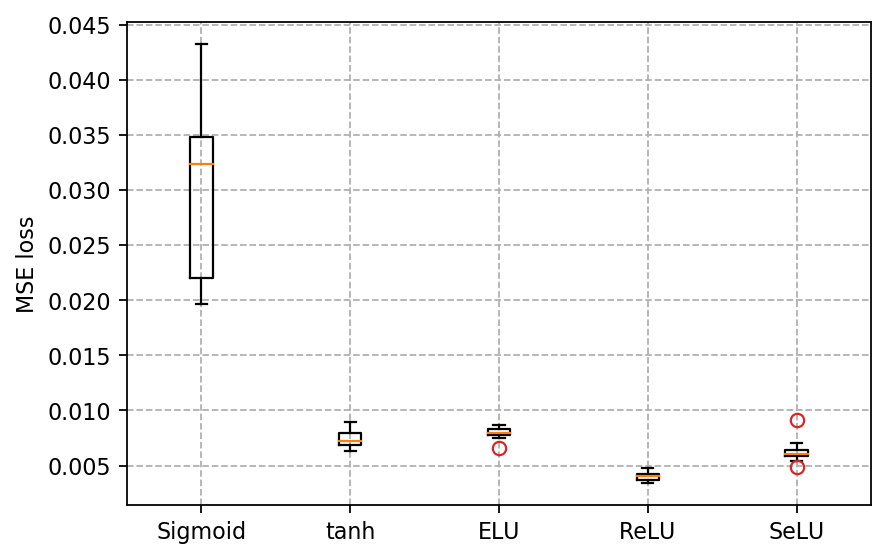

In [21]:
# Box plot
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})    

plt.gca().set_xticklabels(["Sigmoid", "tanh", "ELU", "ReLU", "SeLU"])
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_activations.svg", bbox_inches="tight")

### 4-2. For number of layers

In [22]:
save_temp = f"{output}/temp_1D/"
!mkdir -p $save_temp
layers = [3, 4, 5, 6]
losses = [[], [], [], []]
model_params["activation"] = pt.nn.ReLU()
for i, nl in enumerate(layers):
    model_params["n_layers"] = nl
    for seed in range(10):
        pt.manual_seed(seed)
        model = MappingNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], 1000, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch  1000: 9.50493e-04, 1.88804e-04Training/validation loss epoch    86: 7.31989e-02, 2.64648e-02Training/validation loss epoch   448: 4.80323e-03, 1.43926e-03Training/validation loss epoch   605: 3.38895e-03, 9.81555e-04Training/validation loss epoch   393: 9.08415e-03, 2.28731e-03Training/validation loss epoch   470: 4.16360e-03, 1.20043e-03Training/validation loss epoch   281: 7.39130e-03, 1.43173e-03Training/validation loss epoch   366: 4.83186e-03, 1.41844e-03Training/validation loss epoch   536: 3.17933e-03, 1.04988e-03Training/validation loss epoch   781: 2.08930e-03, 6.90482e-04Training/validation loss epoch   344: 5.48912e-03, 1.66547e-03Training/validation loss epoch   979: 6.32517e-04, 1.95791e-04Training/validation loss epoch   493: 2.19860e-03, 6.30708e-04Training/validation loss epoch   757: 2.06074e-03, 7.96104e-04Training/validation loss epoch   656: 1.52988e-03, 6.83977e-04Training/validation loss epoch   706: 8.70529e-04, 4.82436e-04Trainin

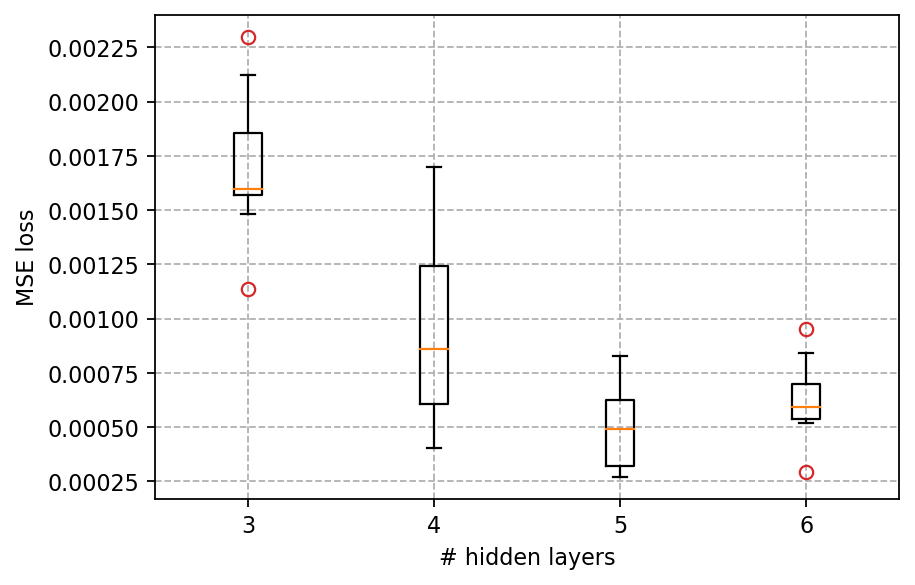

In [23]:
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[layers[i]], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("# hidden layers")
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_layers.svg", bbox_inches="tight")

### 4-3. For learning rate

In [24]:
save_temp = f"{output}/temp_1D/"
!mkdir -p $save_temp
lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]
losses = [[], [], [], [], [], []]
model_params["activation"] = pt.nn.ReLU()
for i, lr in enumerate(lrs):    
    for seed in range(10):
        pt.manual_seed(seed)
        model = MappingNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], lr = lr, epochs = 1000, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch  1000: 8.62346e-03, 9.93323e-03Training/validation loss epoch   540: 6.34475e-02, 2.26299e-02Training/validation loss epoch   584: 4.97310e-02, 1.82017e-02Training/validation loss epoch   285: 1.30129e-01, 4.54494e-02Training/validation loss epoch   412: 7.60559e-02, 2.40691e-02Training/validation loss epoch   738: 3.21356e-02, 1.03830e-02Training/validation loss epoch   884: 1.93248e-02, 5.27470e-03Training/validation loss epoch   253: 1.52861e-01, 7.92090e-02Training/validation loss epoch   376: 9.45325e-02, 3.38624e-02Training/validation loss epoch   401: 1.26756e-01, 4.97119e-02Training/validation loss epoch   251: 1.47694e-01, 6.03806e-02Training/validation loss epoch   512: 6.01384e-02, 1.62892e-02Training/validation loss epoch   100: 2.81179e-01, 2.54634e-01Training/validation loss epoch   457: 1.12453e-01, 4.96197e-02Training/validation loss epoch   610: 4.03570e-02, 1.70645e-02Training/validation loss epoch   470: 1.20757e-02, 2.42395e-03Trainin

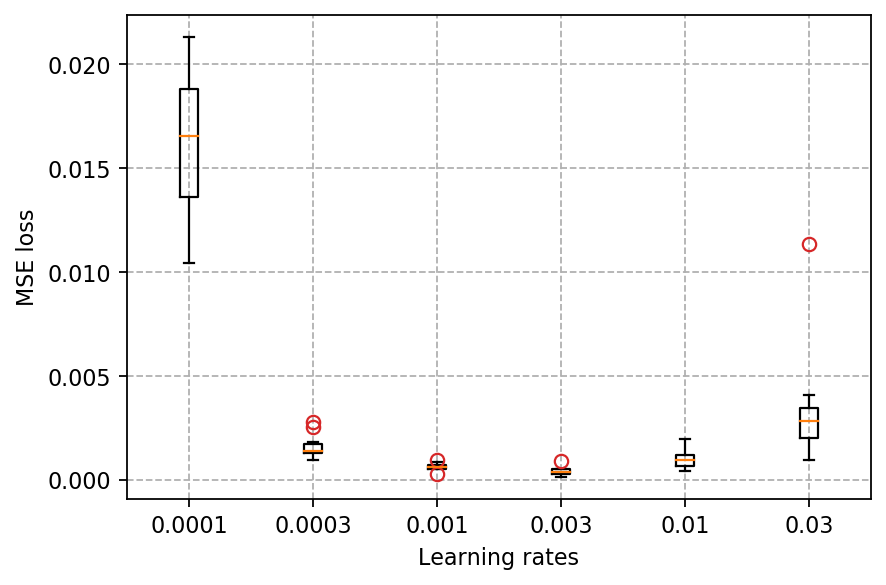

In [25]:
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("Learning rates")
plt.ylabel("MSE loss")
plt.gca().set_xticklabels([lrs[0], lrs[1], lrs[2], lrs[3], lrs[4], lrs[5]])
plt.grid(ls="--")
plt.savefig(f"{output}/profile_learningrates.svg", bbox_inches="tight")

### 4-4. For number of neurons per layer

In [26]:
save_temp = f"{output}/temp_1D/"
!mkdir -p $save_temp
neurons = [20, 30, 40, 50]
losses = [[], [], [], []]
model_params["activation"] = pt.nn.ReLU()
for i, nr in enumerate(neurons):
    model_params["n_neurons"] = nr
    for seed in range(10):
        pt.manual_seed(seed)
        model = MappingNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], 1000, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch  1000: 3.82357e-04, 3.29199e-04Training/validation loss epoch   651: 3.42313e-03, 1.47480e-03Training/validation loss epoch   451: 3.37882e-03, 1.06488e-03Training/validation loss epoch   815: 1.45504e-03, 4.75543e-04Training/validation loss epoch    32: 2.76147e-01, 2.23112e-01Training/validation loss epoch   705: 4.87700e-03, 1.05673e-03Training/validation loss epoch    11: 3.02365e-01, 2.64469e-01Training/validation loss epoch   931: 9.06622e-04, 3.14269e-04Training/validation loss epoch    60: 1.58452e-01, 6.22446e-02Training/validation loss epoch   634: 1.90505e-03, 8.04038e-04Training/validation loss epoch   235: 1.40880e-02, 2.98820e-03Training/validation loss epoch   473: 4.47062e-03, 9.03412e-04Training/validation loss epoch   997: 6.46177e-04, 2.73182e-04Training/validation loss epoch   135: 3.82793e-02, 8.57776e-03Training/validation loss epoch   206: 9.05398e-03, 2.74258e-03Training/validation loss epoch   320: 3.11019e-03, 7.92756e-04Trainin

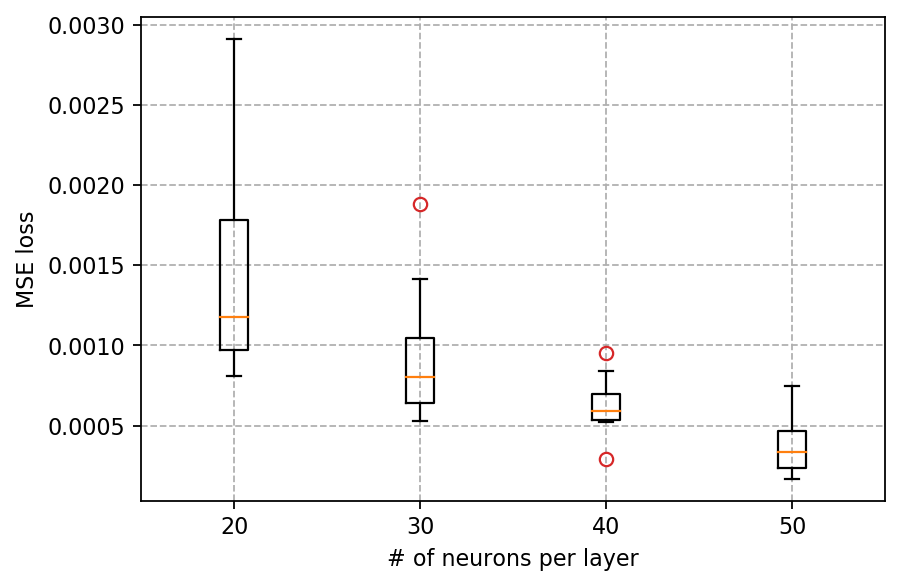

In [27]:
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("# of neurons per layer")
plt.ylabel("MSE loss")
plt.gca().set_xticklabels([neurons[0], neurons[1], neurons[2], neurons[3]])
plt.grid(ls="--")
plt.savefig(f"{output}/profile_neurons.svg", bbox_inches="tight")

#### The best model so far is,

lr = 0.003, number of neurons per layer = 50, number of hidden layers = 5, activation function = ReLU.

Now, the second training is to be started.

In [28]:
# First model training with normalized data
save_model_best = f"{output}/best_training_1D/"
!mkdir -p $save_model_best
model_params = {
    "n_inputs": 2,
    "n_outputs": 3,
    "n_layers": 5,
    "n_neurons": 50,
    "activation": pt.nn.ReLU()
}
model = MappingNN(**model_params)
train_loss, val_loss = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3],
                                      val_data_norm[:, 3:], val_data_norm[:, 0:3], lr = 0.003, epochs = 10000, 
                                      save_best=save_model_best)

 Training/validation loss epoch 10000: 3.83513e-05, 2.58952e-05Training/validation loss epoch   978: 5.09235e-04, 2.53378e-04Training/validation loss epoch  1295: 1.25271e-04, 9.11941e-05Training/validation loss epoch  1971: 2.72841e-04, 1.96106e-04Training/validation loss epoch  2818: 1.28305e-04, 1.24625e-04Training/validation loss epoch  4528: 4.81492e-05, 4.72369e-05Training/validation loss epoch  6174: 1.22218e-04, 9.77391e-05Training/validation loss epoch  6561: 1.10593e-04, 7.81244e-05Training/validation loss epoch  6743: 4.49356e-05, 4.08303e-05Training/validation loss epoch  6811: 1.52005e-04, 1.88558e-04Training/validation loss epoch  9716: 3.41715e-05, 2.77914e-05Training/validation loss epoch  9761: 2.94402e-05, 2.50833e-05

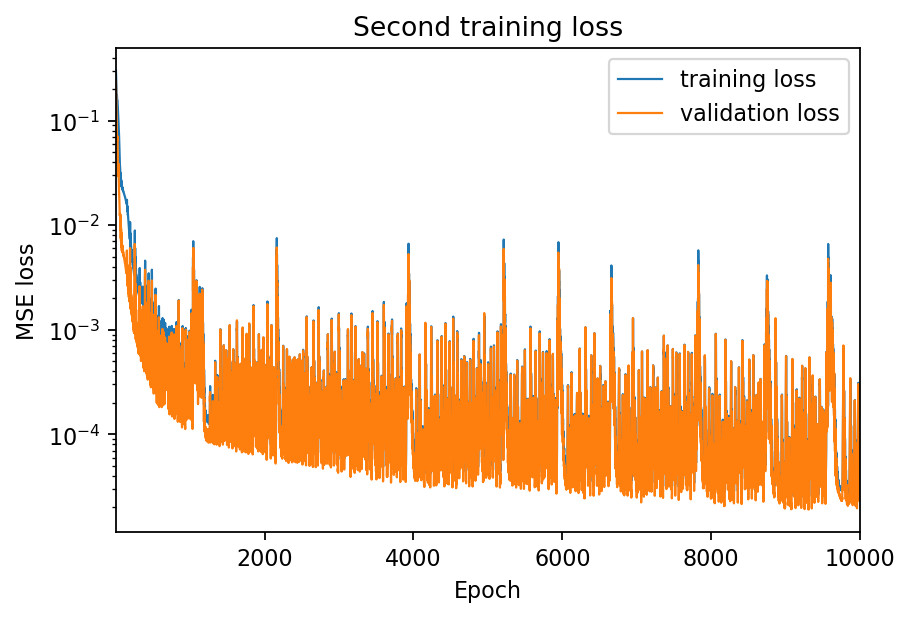

In [29]:
epochs = len(train_loss)
plt.title("Second training loss")
plt.plot(range(1, epochs+1), train_loss, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss, lw=1.0, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss_best.svg", bbox_inches="tight")

In [30]:
# Calculate L_inf again
best_model = MappingNN(**model_params)
best_model.load_state_dict(pt.load(f"{save_model_best}best_model_train.pt"))
prediction = best_model(test_data_norm[:, 3:]).squeeze()
l2 = (prediction - test_data_norm[:, 0:3]).square().mean()
# We normalize the maximum error with the range of the scaled dUdy and Ux_face,
# which is 1-(-1)=2
lmax = (prediction - test_data_norm[:, 0:3]).absolute().max() / 2
print("MSE test loss: {:1.4e}".format(l2))
print("Lmax test loss: {:1.4e}".format(lmax))

MSE test loss: 1.9386e-05
Lmax test loss: 1.4487e-02


**Comparison and plot will be added here.**

## 5. Prediction error of the best model

In [31]:
save_temp_best = f"{output}/temp_1D_best/"
!mkdir -p $save_temp_best

neurons = 50
hidden = 5
lr = 0.003

losses = [[]]
model_params["activation"] = pt.nn.ReLU()
model_params["n_neurons"] = neurons
model_params["n_layers"] = hidden
for seed in range(10):
    pt.manual_seed(seed)
    model = MappingNN(**model_params)
    _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], lr = lr, epochs = 1000, save_best=save_temp_best)
    losses[0].append(
        eval_best_model(
            model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp_best)
    )

 Training/validation loss epoch  1000: 2.91181e-04, 1.08630e-04Training/validation loss epoch   450: 9.72945e-04, 7.50012e-04Training/validation loss epoch    88: 1.22814e-02, 3.46431e-03Training/validation loss epoch   585: 3.85990e-03, 1.24790e-03Training/validation loss epoch   230: 2.19162e-03, 9.54314e-04Training/validation loss epoch   164: 4.83496e-03, 1.31815e-03Training/validation loss epoch   442: 3.81136e-03, 2.22119e-03Training/validation loss epoch   689: 9.35003e-04, 4.72838e-04Training/validation loss epoch   820: 2.02979e-03, 7.17376e-04Training/validation loss epoch   838: 2.39265e-03, 1.82226e-03Training/validation loss epoch   513: 1.47286e-03, 5.96303e-04Training/validation loss epoch   471: 1.05311e-03, 4.51628e-04Training/validation loss epoch   516: 8.61627e-04, 2.92898e-04Training/validation loss epoch   837: 9.83592e-04, 1.22363e-03Training/validation loss epoch   315: 1.71466e-03, 1.35514e-03Training/validation loss epoch   417: 7.52040e-04, 2.49213e-04Trainin

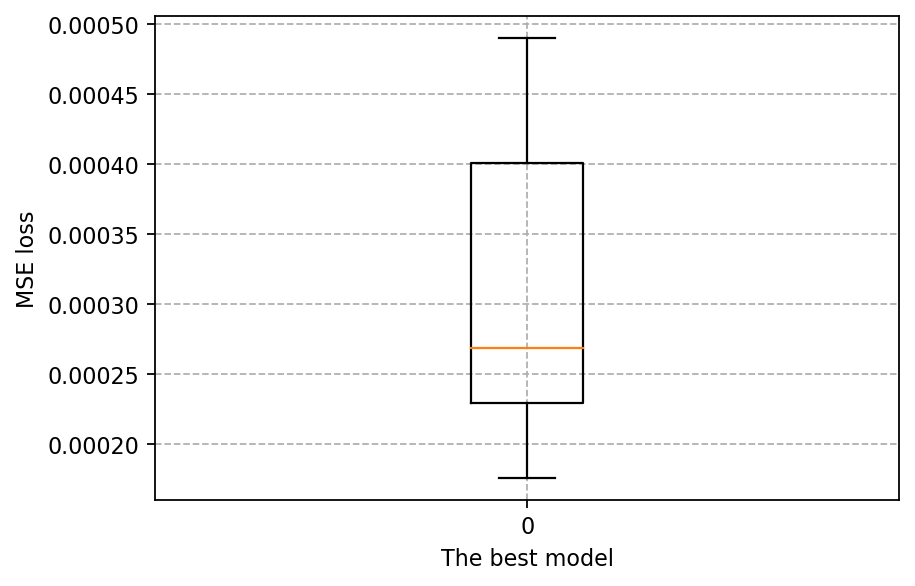

In [32]:
plt.boxplot(np.array(losses[0]), positions=[0], flierprops={
            "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("The best model")
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_bestmodel.svg", bbox_inches="tight")

In [33]:
bestmodel = MappingNN(**model_params)
bestmodel.load_state_dict(pt.load(f"{save_temp_best}best_model_train.pt"))
prediction = bestmodel(full_data_norm[:, 3:]).squeeze().detach()
error = (prediction - full_data_norm[:, 0:3]) / 2 * 100

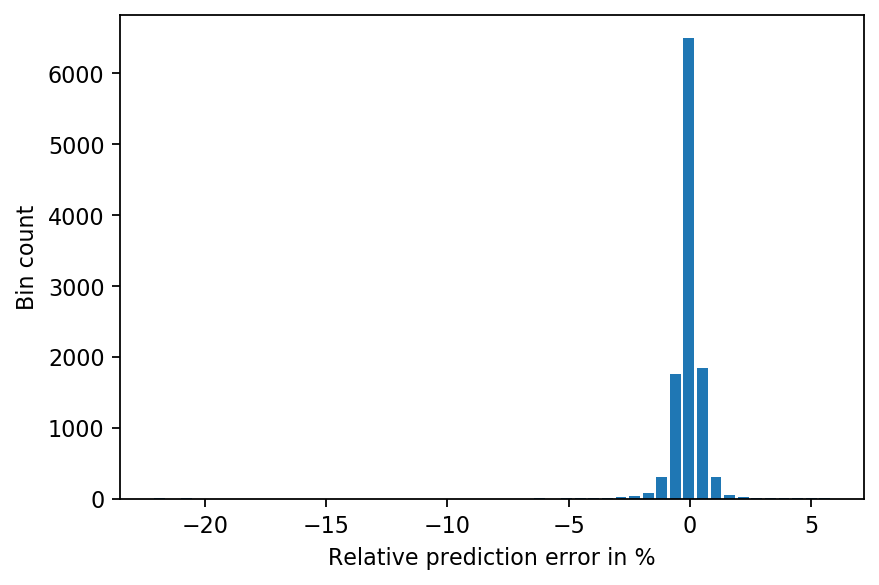

In [34]:
# Histogram for relative error
err_min = error.min().item()
err_max = error.max().item()
counts = pt.histc(error, bins=50, min=err_min, max=err_max).detach()
bin_width = (err_max-err_min) / 50
centers = pt.arange(err_min+0.5*bin_width, err_min +
                    50*bin_width, bin_width).detach()

plt.bar(centers, counts, width=bin_width*0.8)
plt.xlabel("Relative prediction error in %")
plt.ylabel("Bin count")
plt.savefig(f"{output}/profile_error_hist_best.svg", bbox_inches="tight")

In [35]:
# Heat map for maximum relative error
def max_error_map(x: pt.Tensor, err: pt.Tensor, bins: int) -> pt.Tensor:
    """Divide feature space in bins and compute maximum error for each bin.

    Parameters
    ----------
    :param x: feature tensor
    :type x: pt.Tensor
    :param err: absolute error values
    :type err: pt.Tensor
    :param bins: number of bin
    :type bins: int
    
    Return
    ------
    :return: 2D tensor with maximum errors for each bin; if there are N bins,
        the result will be a NxN tensor
    :rtype: pt.Tensor
    """
    step = 2.0 / bins
    bounds_low = pt.arange(-1, 1.0, step)
    bounds_up = pt.arange(-1+step, 1.0+0.5*step, step)
    max_error = pt.zeros((bins, bins))
    for i, (low_i, up_i) in enumerate(zip(bounds_low, bounds_up)):
        for j, (low_j, up_j) in enumerate(zip(bounds_low, bounds_up)):
            errors = pt.where((x[:, 0] >= low_i) & (x[:, 1] >= low_j) & (
                x[:, 0] < up_i) & (x[:, 1] < up_j), err.type(pt.float64), 0.0)
            max_error[i, j] = errors.max()
    return max_error


error_map = max_error_map(full_data_norm[:, 3:], error.abs(), 10)
edges = pt.linspace(-1, 1, 10+1)
xx, yy = pt.meshgrid(edges, edges)
pcol = plt.pcolormesh(xx.detach(), yy.detach(), error_map.detach())
plt.colorbar(pcol, label=r"Maximum relative error in %")
plt.xlabel(r"$avg \tilde{U} $")
plt.ylabel(r"$\tilde{y} face$")
#plt.savefig(f"{output}/profile_error_heatmap_best.svg", bbox_inches="tight")

RuntimeError: The size of tensor a (3650) must match the size of tensor b (3) at non-singleton dimension 1